In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False

In [62]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-noguidance","semantic-zest", "syntactic-noguidance", "syntactic-zest", "afl"]

RANGE=20 #exclusiove range in python

folder = "expfinalfinal"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))


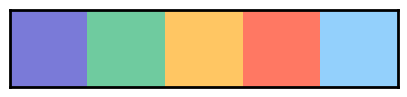

In [3]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [4]:

def process_cov_data(path: str) -> List[str]:
    with open(path) as f:
        return f.readlines()

In [5]:
#read cov-all and cov-valid

cov_data_count = {
    "algo": [],
    "type": [],
    "value": []
}

cov_all_data = []
cov_valid_data = []

def read_this(path, typ):
    cov = process_cov_data(path)
    cov_data_count["algo"].append(algorithm)
    cov_data_count["type"].append(typ)
    cov_data_count["value"].append(len(cov))

    if len(cov) > 0: 
        splits = [c.replace('# Covered: (','').split(') ') for c in cov]
        data = np.array(splits)
        cov,calls = data.T
        method=[c.split('()')[0] for c in calls]
        clazz=[c.split('#')[0] for c in method]
        clazz=[c.split('$')[0] for c in clazz]
        
        cov_int = [int(i) for i in cov]
        
        df=pd.DataFrame({'cov':cov_int, 'clazz':clazz,'method':method,'calls':calls})
        df['clazz'] = pd.Categorical(df['clazz'], categories=set(clazz))
        df['method'] = pd.Categorical(df['method'], categories=set(method))
        
        
        #df.columns = ['cov','class']
        df['algorithm']=[algorithm]*len(cov)

        return df
    return pd.DataFrame()
        

for algorithm in ALGORITHM:
    cov_all_data_algo = []
    cov_valid_data_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        #read cov all
        cov_all_path = os.path.join(path, "cov-all.log")
        if not os.path.exists(cov_all_path): continue
        
        df = read_this(cov_all_path,"all")
        if not df.empty:
            df['run']= [idx] * df.shape[0]
            cov_all_data_algo.append(df)

        
        #read cov valid
        cov_valid_path = os.path.join(path, "cov-valid.log")
        if not os.path.exists(cov_valid_path): continue
        
        df = read_this(cov_valid_path,"valid")
        if not df.empty: 
            df['run']= [idx] * df.shape[0]
            cov_valid_data_algo.append(df)

    if cov_valid_data_algo:
        cov_valid_data.append(pd.concat( cov_valid_data_algo))
    if cov_all_data_algo:
        cov_all_data.append(pd.concat( cov_all_data_algo))

    
cov_valid_data = pd.concat( cov_valid_data)
cov_all_data = pd.concat( cov_all_data)

In [6]:
cov_all_data[cov_all_data['algorithm'] == 'stream-zest']

,cov,clazz,method,calls,algorithm,run


In [7]:
#sns.displot(cov_all_data, x='cov', hue="algorithm", kind='kde')
#sns.displot(cov_valid_data, x='cov', hue="algorithm", kind='kde')


In [8]:
sns.set_theme(style="whitegrid")

#f, ax = plt.subplots(figsize=(48, 8))
#sns.despine(f, left=True, bottom=True)
#sorted_data= cov_all_data.sort_values(by=['clazz'])
#sns.scatterplot(sorted_data,y='cov',x='clazz',hue="algorithm",ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')

In [9]:
#f, ax = plt.subplots(figsize=(48, 8))


#sns.despine(f, left=True, bottom=True)
#sorted_all_cov=cov_all_data.sort_values(by=['clazz'])
#sns.scatterplot(sorted_all_cov,y='algorithm',x='clazz',ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')

In [10]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)
sorted_val_cov=cov_valid_data.sort_values(by=['clazz'])

#plot = sns.displot(sorted_val_cov,x="clazz", hue="algorithm",  hue_order=ALGORITHM, palette=colors, height=10, aspect=5, multiple="dodge")
#plot.set(xticklabels=[])
#plot.set(xlabel=None)




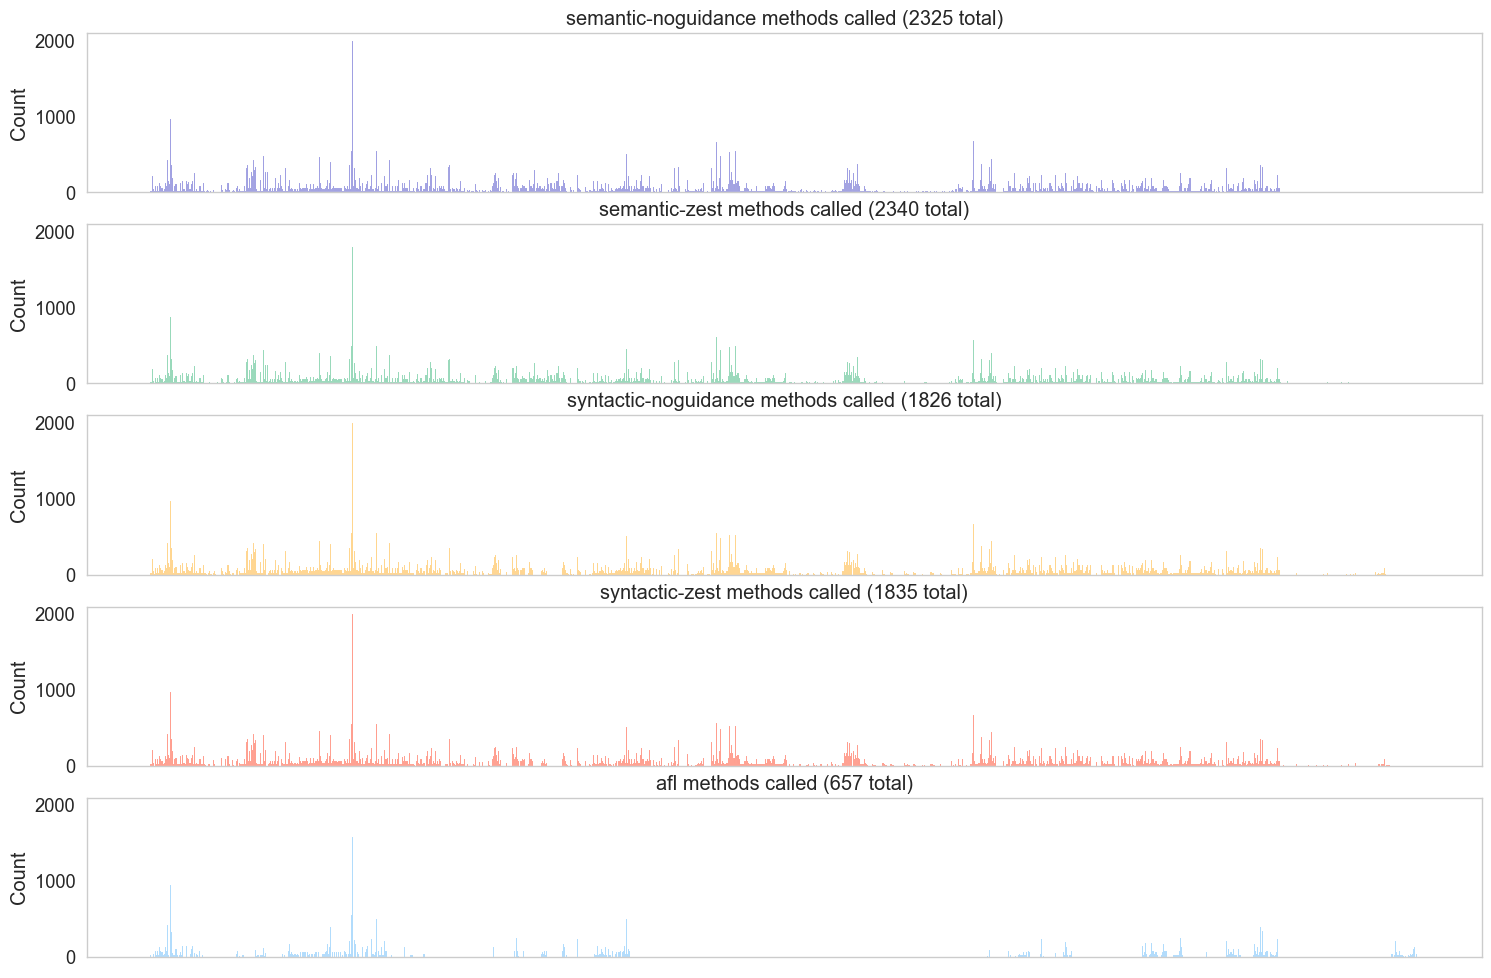

In [11]:
i=0
ll , ax = plt.subplots(5,1, sharey=True, sharex=True, figsize=(18,12))
sorted_cov=cov_all_data.sort_values(by=['method'])
for algo in ALGORITHM:
    algodata= sorted_cov[sorted_cov['algorithm']==algo]
    plot = sns.histplot(algodata["method"], color=colors[i], ax=ax[i])
    c = len(algodata['method'].value_counts())
    plot.set(xticklabels=[])
    plot.set(xlabel=None)
    plot.set_title(f'{algo} methods called ({c} total)')
    i+=1
ll.savefig(f'{pdf_dir}/methods_called.pdf')

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


"for ax in g.axes.flat:\n    for label in ax.get_xticklabels():\n        label.set_rotation(40)\n        label.set_ha('right')"

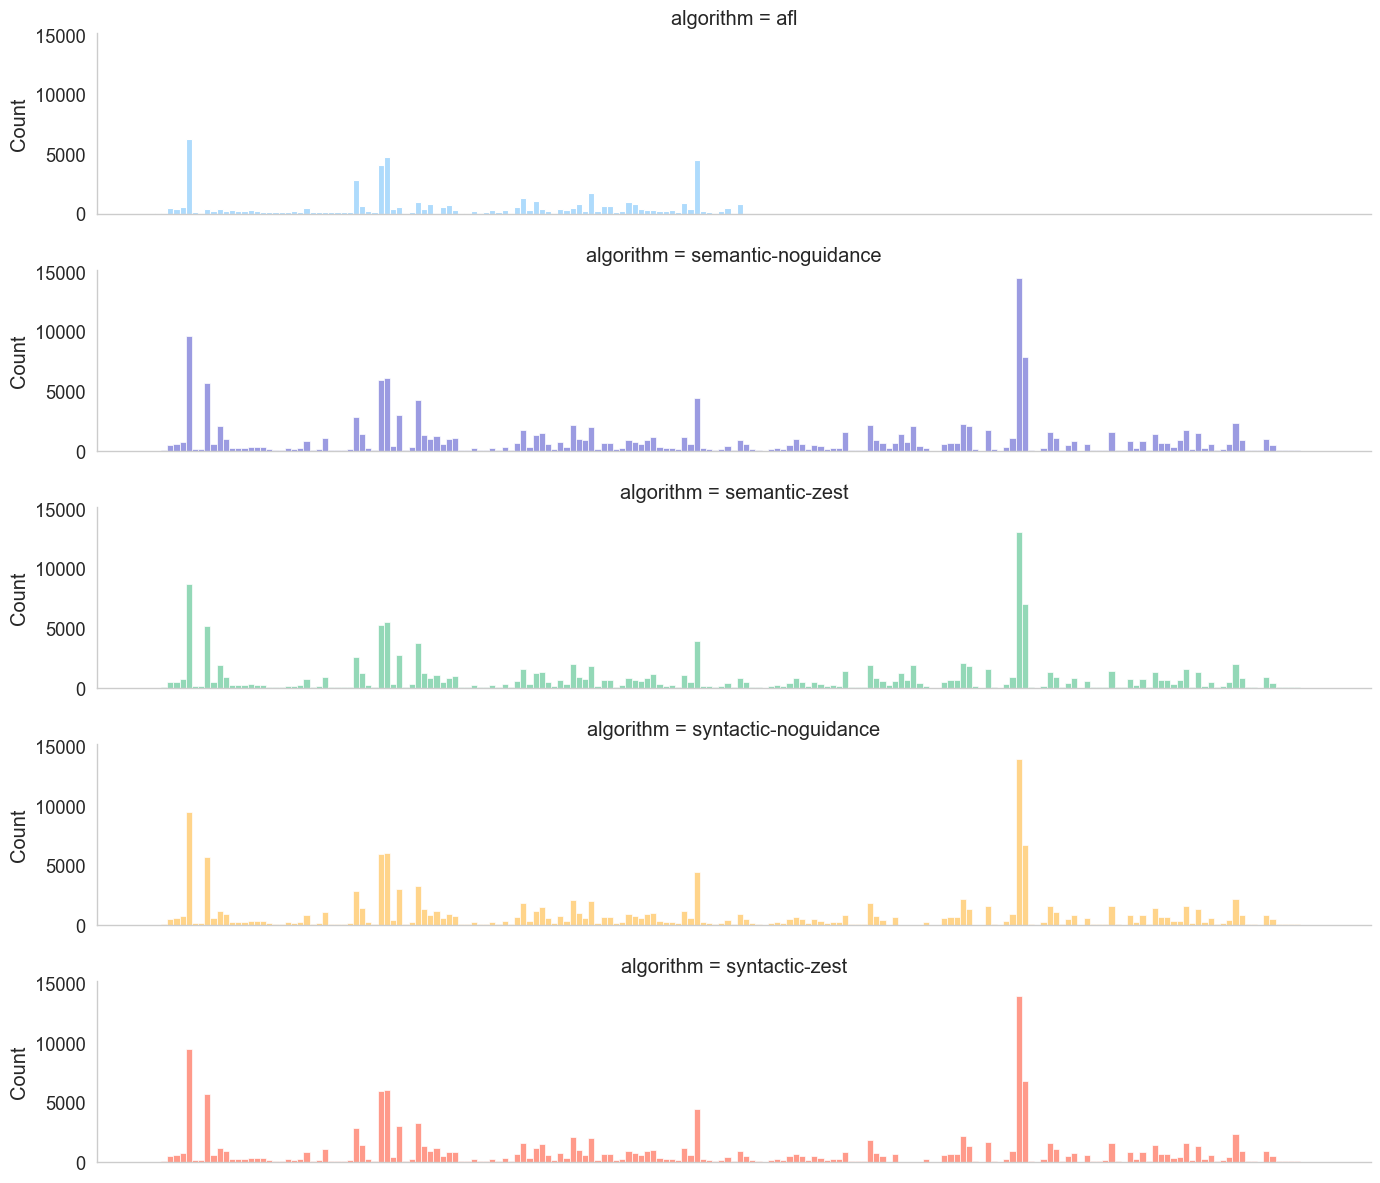

In [38]:

sorted_val_cov=cov_all_data.sort_values(by=['clazz'])

g = sns.FacetGrid(sorted_val_cov, row='algorithm', hue='algorithm', hue_order=ALGORITHM, palette=colors, row_order=sorted(sorted_val_cov['algorithm'].unique()),height=2.5, aspect=6)
g.map(sns.histplot, 'clazz')
g.set(xticklabels=[])
g.set(xlabel=None)
'''for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')'''

In [41]:
g.savefig(f'{pdf_dir}/class_hist_called.pdf')

In [14]:
from matplotlib_venn import venn2,venn3


def venn2_this(df,column,a,b,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    
    # Create a Venn diagram
    venn2([set_a, set_b], (a, b))
    
    # Display the diagram
    plt.title(f'{on} for {a} and {b}')
    plt.show()

def venn3_this(df,column,a,b,c,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    set_c = set(df[df[column].str.contains(c)][on])
    
    # Create a Venn diagram
    venn3([set_a, set_b, set_c], (a, b,c))
    
    # Display the diagram
    plt.title(f'{on} for {a}, {b} and {c}')
    plt.show()



532
532


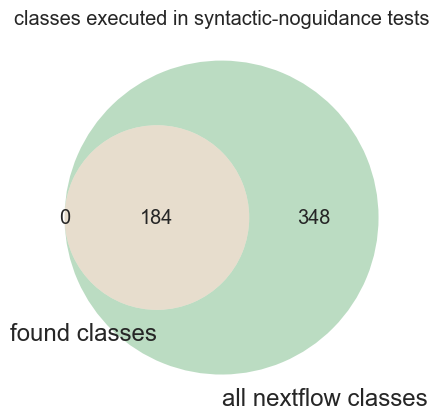

In [45]:
strings_file = "nextflowclasses.txt"


# Create empty output files
found_strings = []
not_found_strings = []
all_classes =[]
algorithm = "syntactic-noguidance"
cov_data_set = set(cov_all_data[cov_all_data['algorithm'].str.contains(algorithm)]['calls'].values)
# Read strings from strings_file and search for them in the DataFrame column 'clazz'
with open(strings_file, 'r') as file:
    for line in file:
        search_string = line.strip()
        all_classes.append(search_string)
        if np.any([search_string in entry for entry in cov_data_set]):
            found_strings.append(search_string)
        else:
            not_found_strings.append(search_string)

print(len(all_classes))

print(len(set(all_classes)))
plot= venn2([set(found_strings),set(all_classes)],("found classes","all nextflow classes"))
if algorithm=='a' : algorithm ='all' 
plt.title(f'classes executed in {algorithm} tests')
plt.savefig(f"{pdf_dir}/classes_found_{algorithm}.pdf")

In [16]:
sem  = set(cov_all_data[cov_all_data['algorithm'].str.contains('syntactic-noguidance')]['clazz'].values)
syn  = set(cov_all_data[cov_all_data['algorithm'].str.contains('semantic-zest')]['clazz'].values)

for s in syn:
    if s not in sem:
        print(s) 

print('--')

for s in sem:
    if s not in syn:
        print(s) 


nextflow/extension/DataflowHelper
nextflow/script/TokenMultiMapDef
nextflow/extension/OpCall
nextflow/processor/ErrorStrategy
nextflow/extension/MultiMapOp
nextflow/extension/CaptureProperties
nextflow/extension/OperatorImpl
--
nextflow/io/ByteBufferBackedInputStream
nextflow/util/CharsetHelper


In [17]:
'''
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','cov')
venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','clazz')

venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','cov')
venn3_this(cov_all_data,'algorithm','zest','noguidance','afl','cov')

venn3_this(cov_all_data,'algorithm','semantic','syntactic','stream','cov')
'''


"\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','cov')\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','clazz')\n\nvenn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','cov')\nvenn3_this(cov_all_data,'algorithm','zest','noguidance','afl','cov')\n\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','stream','cov')\n"

In [18]:
'''
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','method')

venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')
'''

"\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')\nvenn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','method')\n\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','method')\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')\n"

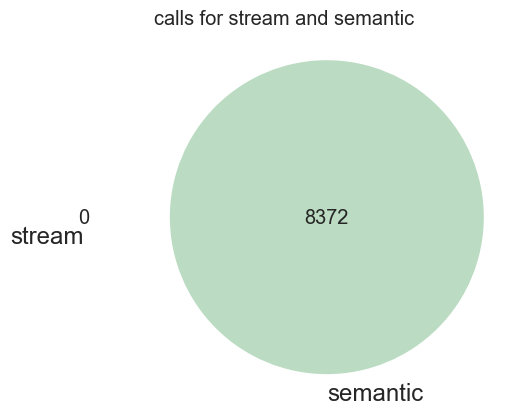

In [19]:
venn2_this(cov_all_data,'algorithm','stream','semantic','calls')


<Axes: >

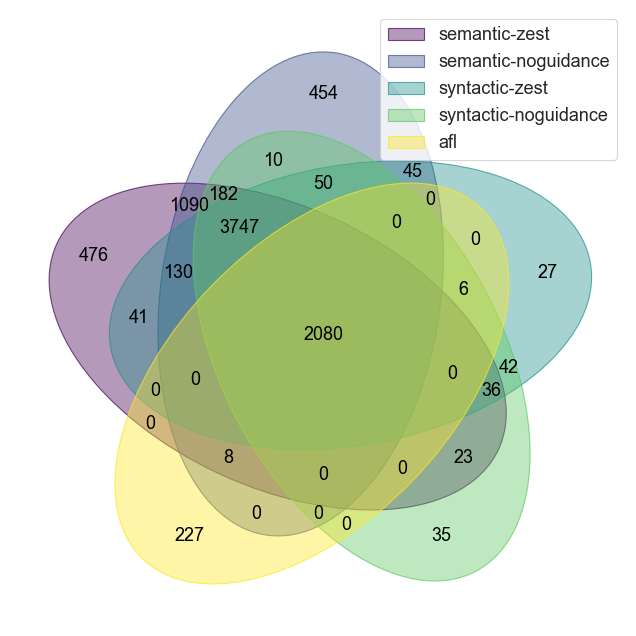

In [20]:
from venn import venn
%matplotlib inline
df=cov_all_data
column='algorithm'
on='calls'
a='semantic-zest'
b='semantic-noguidance'
c='syntactic-zest'
d='syntactic-noguidance'
e='afl'
#f='stream'
data = {
    a : set(df[df[column].str.contains(a)][on]),
    b : set(df[df[column].str.contains(b)][on]),
    c : set(df[df[column].str.contains(c)][on]),
    d : set(df[df[column].str.contains(d)][on]),
    e : set(df[df[column].str.contains(e)][on]),
 #   f : set(df[df[column].str.contains(f)][on]),
    
}

venn(data)


<Axes: >

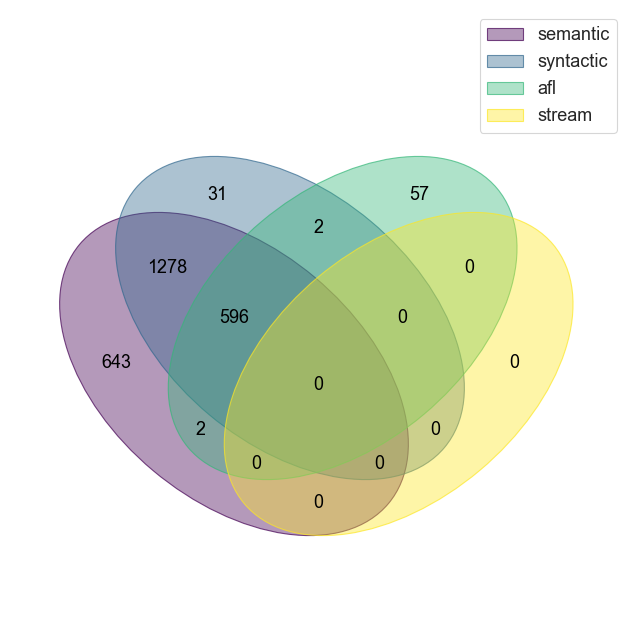

In [21]:
from venn import venn
%matplotlib inline
df=cov_all_data
column='algorithm'
on='method'
a='semantic'
c='syntactic'
e='afl'
f='stream'
data = {
    a : set(df[df[column].str.contains(a)][on]),
    c : set(df[df[column].str.contains(c)][on]),
    e : set(df[df[column].str.contains(e)][on]),
    f : set(df[df[column].str.contains(f)][on]),
    
}

venn(data)

In [39]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 10
            value = str(int(p.get_height()))
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for _, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def generate_total_coverage_bar(data: Dict[str, List[Any]], path: str):
    f, ax = plt.subplots(figsize=(8,5))
    pal= sns.color_palette(colors)
    axis = sns.barplot(x="type", y="value", hue="algo", data=data,  hue_order=ALGORITHM, errorbar="se", ax=ax, palette=colors)
    show_values_on_bars(axis)
    axis.legend(loc='center right')
    
    fig = axis.get_figure()
    fig.savefig(path)
    #fig.clf()
    fig.show()



C:\Users\Alena\AppData\Local\Temp\ipykernel_24300\672657233.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


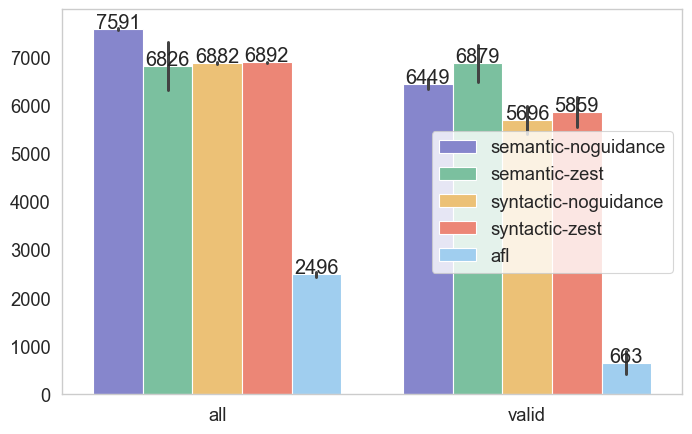

In [40]:

generate_total_coverage_bar(cov_data_count, f'{pdf_dir}/cov_data_count.pdf')


In [57]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100


In [76]:
df =pd.DataFrame(cov_data_count)
print(df.groupby(['algo','type']).agg({'value':['std','min','max','mean']}))
df.groupby(['algo','type']).agg({'value': lambda x: cv(x) })

                                  value                         
                                    std   min   max         mean
algo                 type                                       
afl                  all     220.208192  2361  2887  2496.380952
                     valid  1074.347658     0  2334   663.095238
semantic-noguidance  all      91.162283  7406  7768  7591.809524
                     valid   491.865225  6065  7346  6449.000000
semantic-zest        all    2278.013709     0  7865  6826.571429
                     valid  1674.466926     0  7557  6879.473684
syntactic-noguidance all      80.507704  6628  7010  6882.095238
                     valid  1362.948843     0  6607  5696.619048
syntactic-zest       all      75.458314  6790  7078  6892.571429
                     valid  1414.023562     0  6747  5859.666667


value
algo                 type             
afl                  all      8.821097
                     valid  162.020114
semantic-noguidance  all      1.200798
                     valid    7.627000
semantic-zest        all     33.369807
                     valid   24.340044
syntactic-noguidance all      1.169814
                     valid   23.925575
syntactic-zest       all      1.094777
                     valid   24.131468

In [82]:
afl = cov_valid_data[cov_valid_data['algorithm'] == 'afl']
afl.groupby(['run'])['calls'].count()

run
0     2324
2     2334
4     2315
7     2327
9     2318
18    2307
Name: calls, dtype: int64

In [69]:
fuzzer_stats ={
"start_time"        : [], 
"last_update"       : [], 
"fuzzer_pid"        : [], 
"cycles_done"       : [], 
"execs_done"        : [], 
"execs_per_sec"     : [], 
"paths_total"       : [], 
"paths_favored"     : [], 
"paths_found"       : [], 
"paths_imported"    : [],     
"max_depth"         : [], 
"cur_path"          : [], 
"pending_favs"      : [], 
"pending_total"     : [], 
"variable_paths"    : [],     
"stability"         : [], 
"bitmap_cvg"        : [], 
"unique_crashes"    : [],     
"unique_hangs"      : [], 
"last_path"         : [], 
"last_crash"        : [], 
"last_hang"         : [], 
"execs_since_crash" : [],     
"exec_timeout"      : [], 
"afl_banner"        : [], 
"afl_version"       : [], 
"target_mode"       : [], 
"command_line"      : []    
}
base_path = f"C:\\Users\\Alena\\fulldownload\\exp3\\exp3"

for i in range(0,RANGE):
    path = os.path.join(base_path, f"nextflow-afl-{i}", "fuzz-results","fuzzer_stats")
    data = process_cov_data(path)
    splits = [l.split(':') for l in data ]
    for s,n in splits:
        stat = n.strip()
        fuzzer_stats[s.strip()].append(int(stat) if stat.isdecimal() else stat)
ndafull = pd.DataFrame(fuzzer_stats)

ndafull['execs_done'].describe()
ndafull['execs_done'].sum()


84938

In [64]:
d= cov_all_data[cov_all_data['algorithm']=='afl']
d = d.groupby(['run'])['calls'].count()
print(d.mean())
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
print(cv(d))
print(d.std())

2496.3809523809523
8.82109724979356
220.20819153484646


In [67]:
base_path = f"C:\\Users\\Alena\\source\\repos\\growe\\expfinalfinal"

fuzzer_stats ={
"start_time"        : [], 
"last_update"       : [], 
"fuzzer_pid"        : [], 
"cycles_done"       : [], 
"execs_done"        : [], 
"execs_per_sec"     : [], 
"paths_total"       : [], 
"paths_favored"     : [], 
"paths_found"       : [], 
"paths_imported"    : [],     
"max_depth"         : [], 
"cur_path"          : [], 
"pending_favs"      : [], 
"pending_total"     : [], 
"variable_paths"    : [],     
"stability"         : [], 
"bitmap_cvg"        : [], 
"unique_crashes"    : [],     
"unique_hangs"      : [], 
"last_path"         : [], 
"last_crash"        : [], 
"last_hang"         : [], 
"execs_since_crash" : [],     
"exec_timeout"      : [], 
"afl_banner"        : [], 
"afl_version"       : [], 
"target_mode"       : [], 
"command_line"      : []    
}

for i in range(0,RANGE):
    path = os.path.join(base_path, f"nextflow-afl-{i}", "fuzz-results","fuzzer_stats")
    data = process_cov_data(path)
    splits = [l.split(':') for l in data ]
    for s,n in splits:
        stat = n.strip()
        fuzzer_stats[s.strip()].append(int(stat) if stat.isdecimal() else stat)
ndanf = pd.DataFrame(fuzzer_stats)

ndanf['execs_done'].describe()
ndanf['execs_done'].sum()


81739

In [71]:
print(ndafull['bitmap_cvg'].describe())
print(ndanf['bitmap_cvg'].describe())



count        20
unique        1
top       0.00%
freq         20
Name: bitmap_cvg, dtype: object
count        20
unique        4
top       3.47%
freq         14
Name: bitmap_cvg, dtype: object
